# **Image Quality experiments**

In [1]:
import os
import sys
import cv2 as cv
import matplotlib.pyplot as plt

sys.path.insert(0, "..\\Scripts")

from ImagePipeline import ImagePipeline

%matplotlib inline

### **Utils**

In [2]:
path_degraded = "./../Dataset/val_set_degraded"
path = "./../Dataset/val_set"

In [3]:
output_dir = "quality_analysis_results"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [4]:
# Lista di immagini specifiche da analizzare
paths_degraded_example = [
    os.path.join(path_degraded, "val_002802.jpg"),  # Salt and pepper noise
    os.path.join(path_degraded, "val_003425.jpg"),  # Compression artifacts
    os.path.join(path_degraded, "val_000193.jpg"),  # Blurring
    os.path.join(path_degraded, "val_000247.jpg"),  # Pixelation
    os.path.join(path_degraded, "val_000254.jpg"),  # JPEG compression
    os.path.join(path_degraded, "val_000414.jpg"),  # Blur + Salt and pepper noise
    os.path.join(path_degraded, "val_010335.jpg"),  # Original
]

paths_example = [
    os.path.join(path, "val_010332.jpg"),  # Salt and pepper noise
    os.path.join(path, "val_000189.jpg"),  # Compression artifacts
    os.path.join(path, "val_000193.jpg"),  # Blurring
    os.path.join(path, "val_000247.jpg"),  # Pixelation
    os.path.join(path, "val_000254.jpg"),  # JPEG compression
    os.path.join(path, "val_000414.jpg"),  # Blur + Salt and pepper noise
    os.path.join(path, "val_010335.jpg"),  # Original
]

## **Analysis of the image quality**

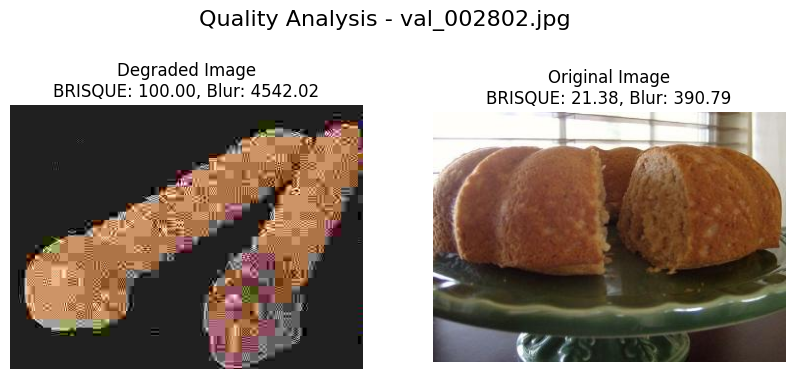

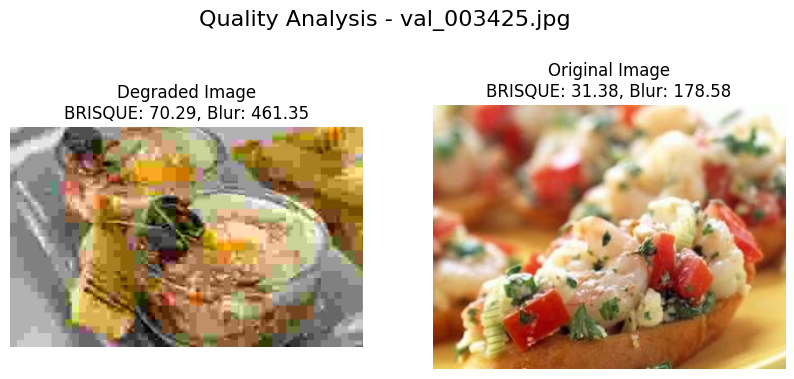

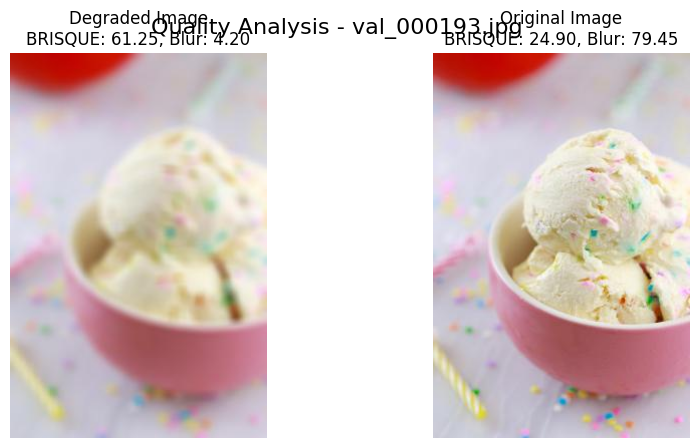

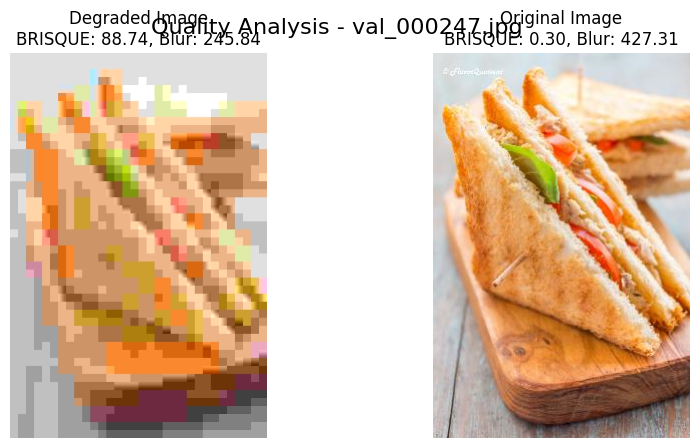

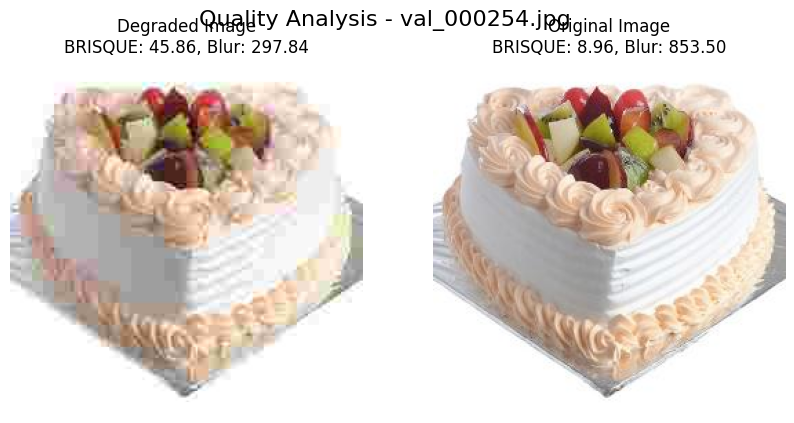

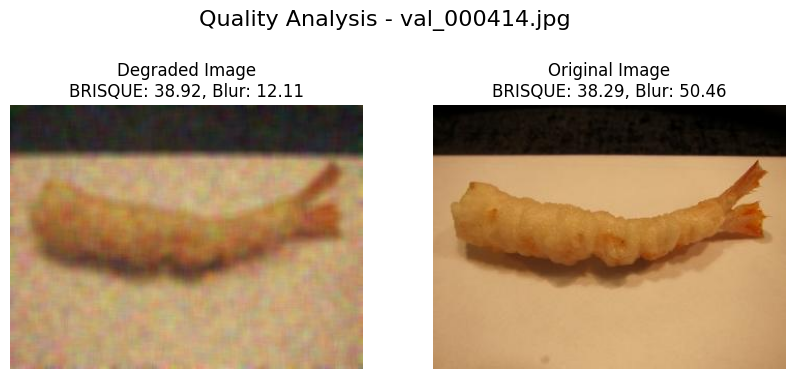

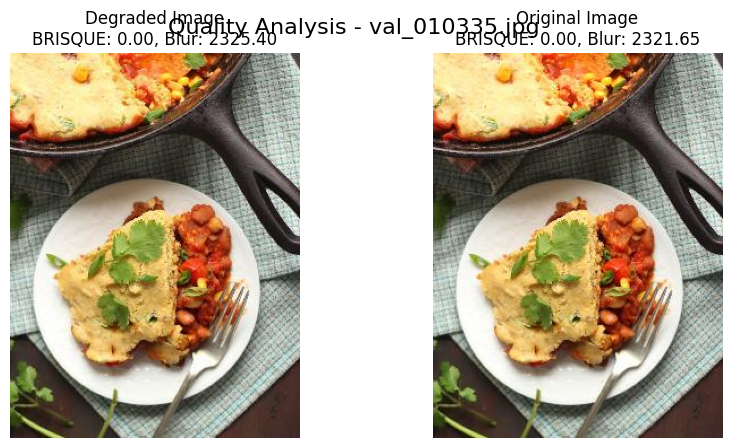

In [5]:
for degraded_path, original_path in zip(paths_degraded_example, paths_example):
    try:
        # Read image
        degraded_img = cv.imread(degraded_path)
        original_img = cv.imread(original_path)

        if degraded_img is None or original_img is None:
            print(
                f"Errore nella lettura delle immagini: {degraded_path} o {original_path}"
            )
            continue

        # Grayscale conversion
        degraded_grey = cv.cvtColor(degraded_img, cv.COLOR_BGR2GRAY)
        original_grey = cv.cvtColor(original_img, cv.COLOR_BGR2GRAY)

        # Blur detection
        degraded_blur = cv.Laplacian(degraded_grey, cv.CV_64F).var()
        original_blur = cv.Laplacian(original_grey, cv.CV_64F).var()

        # BRISQUE quality assessment
        degraded_brisque = cv.quality.QualityBRISQUE_compute(
            degraded_img,
            "./../Scripts/Quality/brisque_model_live.yml",
            "./../Scripts/Quality/brisque_range_live.yml",
        )[0]

        original_brisque = cv.quality.QualityBRISQUE_compute(
            original_img,
            "./../Scripts/Quality/brisque_model_live.yml",
            "./../Scripts/Quality/brisque_range_live.yml",
        )[0]

        # Conversione da BGR a RGB per matplotlib
        degraded_rgb = cv.cvtColor(degraded_img, cv.COLOR_BGR2RGB)
        original_rgb = cv.cvtColor(original_img, cv.COLOR_BGR2RGB)

        # Creazione della figura con subplot
        plt.figure(figsize=(10, 5))

        # Subplot per l'immagine degradata
        plt.subplot(1, 2, 1)
        plt.imshow(degraded_rgb)
        plt.title(
            f"Degraded Image\nBRISQUE: {degraded_brisque:.2f}, Blur: {degraded_blur:.2f}"
        )
        plt.axis("off")

        # Subplot per l'immagine originale
        plt.subplot(1, 2, 2)
        plt.imshow(original_rgb)
        plt.title(
            f"Original Image\nBRISQUE: {original_brisque:.2f}, Blur: {original_blur:.2f}"
        )
        plt.axis("off")

        # Aggiungi un titolo generale
        plt.suptitle(
            f"Quality Analysis - {os.path.basename(degraded_path)}", fontsize=16, y=0.95
        )

        # Salva la figura
        output_filename = os.path.join(
            output_dir, f"comparison_{os.path.basename(degraded_path)}"
        )
        plt.show()

    except Exception as e:
        print(f"Errore nell'elaborazione delle immagini {degraded_path}: {str(e)}")

## **Experiments**

In [ ]:
import numpy as np
import pandas as pd
from ImageDatastore import ImageDatastore

from tqdm import tqdm

In [ ]:
df = pd.read_csv("./../Dataset/val_info.csv", header=None)
df.columns = ["Image", "Label"]
df.head()


Image  Label
0  val_010323.jpg    247
1  val_010324.jpg    234
2  val_010325.jpg    222
3  val_010326.jpg    240
4  val_010327.jpg    218

In [ ]:
x_train = np.load(os.path.join('..', 'Features', 'features', 'x_train.npy'))
y_train = np.load(os.path.join('..', 'Features', 'labels', 'y_train.npy'))

x_train.shape, y_train.shape

((33354, 1280), (33354,))

In [ ]:
x_val = np.load(os.path.join('..', 'Features', 'features', 'x_val_deg.npy'))
y_val = np.load(os.path.join('..', 'Features', 'labels', 'y_val_deg.npy'))

x_val.shape, y_val.shape

((11994, 1280), (11994,))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(
    n_neighbors=31, n_jobs=-1, weights="distance", metric="cosine"
)
knn.fit(x_train, y_train)

KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=31,
                     weights='distance')

In [ ]:
pred = knn.predict(x_val)
df['Predicted'] = pred
df.head()

Image  Label  Predicted
0  val_010323.jpg    247        195
1  val_010324.jpg    234         11
2  val_010325.jpg    222         41
3  val_010326.jpg    240         69
4  val_010327.jpg    218         18

In [ ]:
brisque = []

for i, row in tqdm(df.iterrows()):
    im = cv.imread(os.path.join(path_degraded, row["Image"]))
    brisque.append(
        cv.quality.QualityBRISQUE_compute(
            im,
            "./../Scripts/Quality/brisque_model_live.yml",
            "./../Scripts/Quality/brisque_range_live.yml",
        )[0]
    )

df["BRISQUE"] = brisque
df.head()

0it [00:00, ?it/s]

11994it [08:55, 22.40it/s]


Image  Label  Predicted    BRISQUE
0  val_010323.jpg    247        195   2.421555
1  val_010324.jpg    234         11  40.879032
2  val_010325.jpg    222         41  70.676094
3  val_010326.jpg    240         69  44.190628
4  val_010327.jpg    218         18  34.317459

In [ ]:
df.to_csv("quality_analysis_results/val_info.csv", index=False)

In [ ]:
df[df['Label'] != df['Predicted']].describe()

Label     Predicted       BRISQUE
count  11948.000000  11948.000000  11948.000000
mean     122.673669    127.005105     38.441326
std       72.824057     73.701925     26.456559
min        0.000000      0.000000      0.000000
25%       58.000000     60.000000     14.940002
50%      123.000000    128.000000     32.345198
75%      185.000000    188.000000     62.363351
max      250.000000    250.000000    100.000000

In [ ]:
df[df['Label'] == df['Predicted']].describe()

Label   Predicted    BRISQUE
count   46.000000   46.000000  46.000000
mean   117.195652  117.195652  36.657530
std     80.212113   80.212113  27.284020
min      3.000000    3.000000   2.807487
25%     49.000000   49.000000  12.742717
50%    100.000000  100.000000  25.421665
75%    187.500000  187.500000  62.493316
max    244.000000  244.000000  80.092392

## **Evaluation**

In [6]:
import numpy as np

[3, 3, 64, 23, 32, 2]
Skipping image processing for ./../Dataset/val_set_degraded\val_002802.jpg
Skipping image processing for ./../Dataset/val_set_degraded\val_000247.jpg


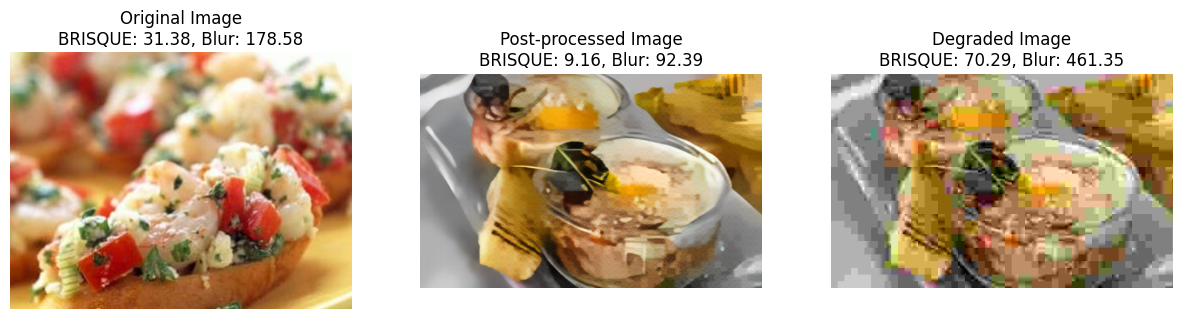

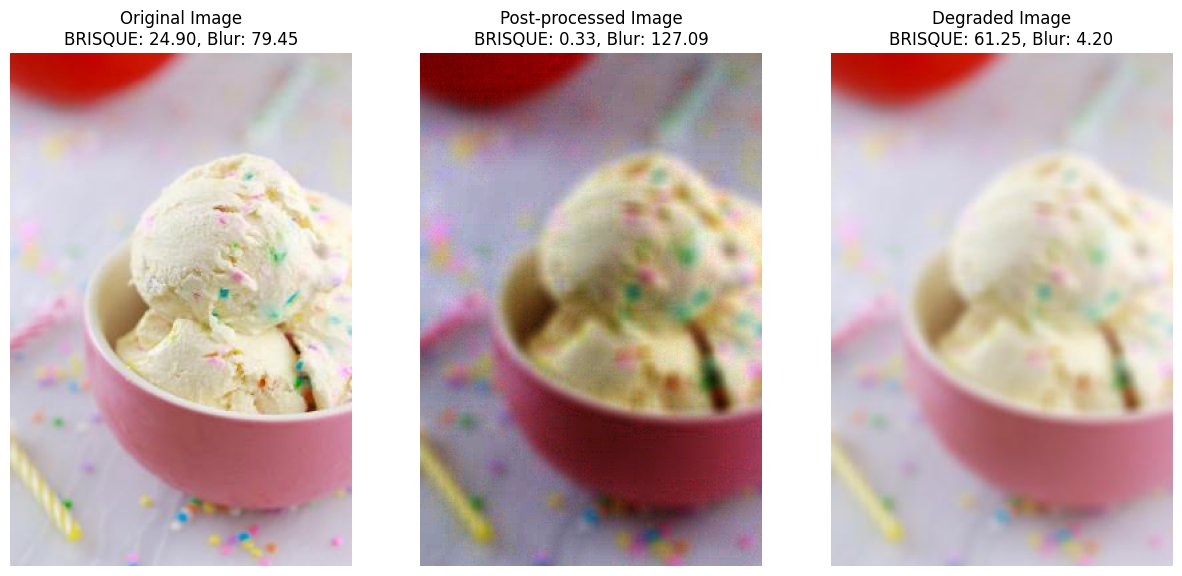

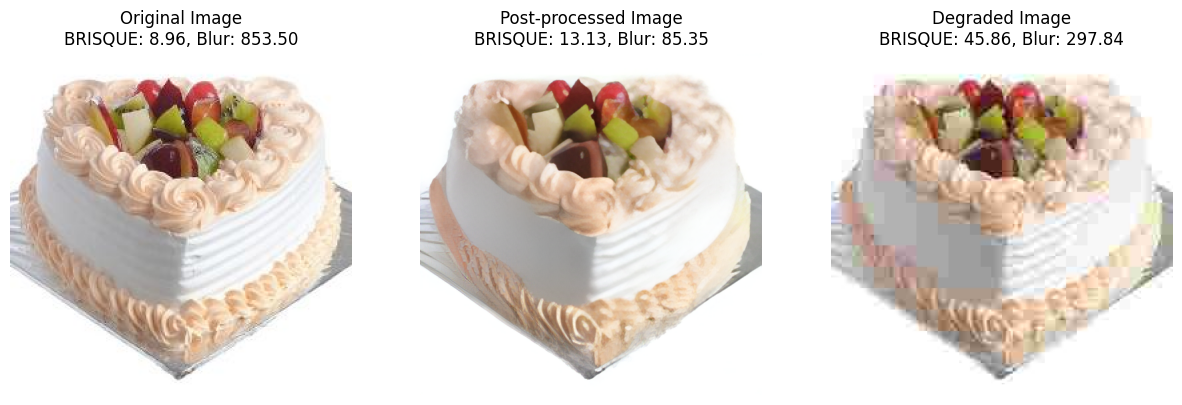

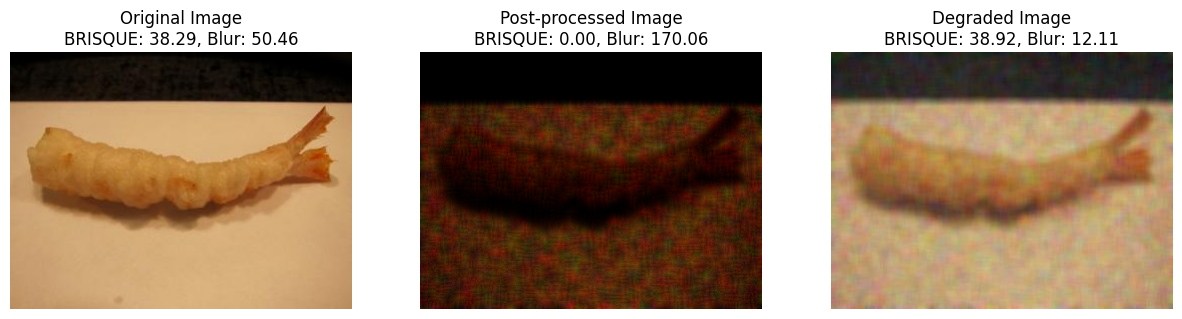

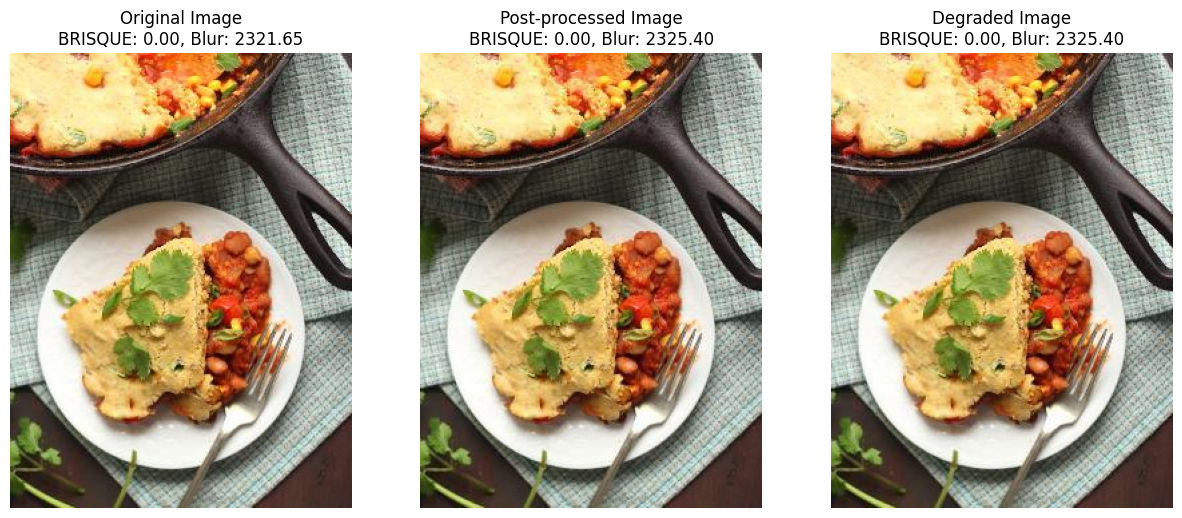

In [ ]:
pipe = ImagePipeline(None, None)

for degraded_path, original_path in zip(paths_degraded_example, paths_example):
    orig_image = cv.imread(original_path)
    degraded_image = cv.imread(degraded_path)
    post_image = pipe.preprocess(degraded_image, (20, 80))
    
    # Check if post_image is a valid image
    if post_image is None or (isinstance(post_image, int) and post_image == -1):
        print(f"Skipping image processing for {degraded_path}")
        continue

    # Ensure post_image is a color image
    if len(post_image.shape) < 3:
        post_image = cv.cvtColor(post_image, cv.COLOR_GRAY2BGR)
    
    if post_image.dtype != np.uint8:
        post_image = (post_image * 255).astype(np.uint8)

    # Grayscale conversion
    degraded_gray = cv.cvtColor(degraded_image, cv.COLOR_BGR2GRAY)
    original_gray = cv.cvtColor(orig_image, cv.COLOR_BGR2GRAY)
    post_gray = cv.cvtColor(post_image, cv.COLOR_BGR2GRAY)

    # Blur detection
    degraded_blur = cv.Laplacian(degraded_gray, cv.CV_64F).var()
    original_blur = cv.Laplacian(original_gray, cv.CV_64F).var()
    post_blur = cv.Laplacian(post_gray, cv.CV_64F).var()

    # BRISQUE quality assessment
    degraded_brisque = cv.quality.QualityBRISQUE_compute(
        degraded_image,
        "./../Scripts/Quality/brisque_model_live.yml",
        "./../Scripts/Quality/brisque_range_live.yml",
    )[0]

    original_brisque = cv.quality.QualityBRISQUE_compute(
        orig_image,
        "./../Scripts/Quality/brisque_model_live.yml",
        "./../Scripts/Quality/brisque_range_live.yml",
    )[0]

    post_brisque = cv.quality.QualityBRISQUE_compute(
        post_image,
        "./../Scripts/Quality/brisque_model_live.yml",
        "./../Scripts/Quality/brisque_range_live.yml",
    )[0]

    plt.figure(figsize=(15, 10))
    
    # Subplot per l'immagine originale
    plt.subplot(1, 3, 1)
    plt.imshow(cv.cvtColor(orig_image, cv.COLOR_BGR2RGB))
    plt.title(
        f"Original Image\nBRISQUE: {original_brisque:.2f}, Blur: {original_blur:.2f}"
    )
    plt.axis("off")

    # Subplot per l'immagine degradata
    plt.subplot(1, 3, 3)
    plt.imshow(cv.cvtColor(degraded_image, cv.COLOR_BGR2RGB))
    plt.title(
        f"Degraded Image\nBRISQUE: {degraded_brisque:.2f}, Blur: {degraded_blur:.2f}"
    )
    plt.axis("off")
    
    # Subplot per l'immagine post-elaborata
    plt.subplot(1, 3, 2)
    plt.imshow(cv.cvtColor(post_image, cv.COLOR_BGR2RGB))
    plt.title(
        f"Post-processed Image\nBRISQUE: {post_brisque:.2f}, Blur: {post_blur:.2f}"
    )
    plt.axis("off")
    